# Empirical Assignment 1

At the end of 1989, early 1990 a perfect storm in credit markets appeared. Drexel
Burnham, the key player in the junk bond market went bankrupt. The Financial Institutions
Reform, Recovery, and Enforcement Act (FIRREA) was passed, forcing all savings and loans
institutions to eliminate any speculative grade debt from their balance sheets. The national
association of Insurance Companies changed their ratings scale in such a way as to
incentivize insurance companies - significant investors in corporate bonds - to sharply
reduce their junk bond holdings. Finally, a crash in real estate prices in the Northeast lead
to a severe contraction of bank lending, often referred to as a “capital crunch”.
Undertake a difference-in-differences analysis of nonfinancial corporate behavior
(investment and financing policy), using a data window encompassing 1985 through 1994
and the end of 1989 as the “event date” and the set of US publicly traded companies.
Begin by downloading all available data on US non-financial firms from COMPUSTAT
Capital IQ for the period 1985-1994. Condition on firm-year observations with a valid
credit rating, and non-missing values for the data items to be used in the analysis (see table
at bottom). Note, the controls will be lagged one period relative to the outcome variables,
so condition on non-missing data for the outcome variables in period t, but non-missing
data for the controls in period t-1.

# Paper
Preamble
- Always start with the problem then the approach and the results, then dive in
- what is the problem, what are they trying to do
- what determines corp leverage and what determines financing
- find something that shifts on one of the two related measures (e.g. Supply vs Demand)
- endogeneity is the problem in corp fin
- shocking the system with endog events you can disentangle these
- looking for causal effect of the treatment using DiD
- examines three shocks to supply of credit
- identifying a link btwn supply of capital and corp behaviour using DiD
- background
- verification that events were exogenous to demand
- "statistical twins": propensity score for mapping btwn treatment and control
- if you just average the control you'll mess up the trends
- ASSIGNMENT: you'll need a fixed effects option in the ols library


# Assignment

## approach
- use the wrds library
- use fixed effects (OR just don't take fixed effects into account and look at the deviation from the group mean)
- you'll have fixed effects(STRUCUTRE IN THE CONDITIONAL MEAN) for time (vt) and fixed effects for a single firm across time (lambda), calculate the means and then demean the data
- - otherwise yo';ll have a bunch of stuff that is correlated with Xb
- - either look up how to handle panel data with fixed effects or just demean the data yourself.
- the problem with corp fin is that you have to cross match datasets

## setup
- helper fns for bond ratings, j. vs ig., to group for qn 6
- helper fn: windsorize
- helper fn: growth rate
- db = wrds.Connection()
- indicators that wil filter based on credit ratings for treatment/control
- LOOKUP panelOLS library
- LOOKUP how to drop non-financial firms, drop all GIC=40. Find all SIC codes that are financials, utilities, etc.


## data
- toss away banks right out the gate b/c they are marked ot the market
- you'll need stuff like: comp_na_daily_all, comp_na_annual_all
- go to "Data Preview" in WRDS
- PRSTK (just toss 0 in for N/A for preferred stock b/c no one cares about their preferred stock)
- MtB: use (M.Eq + B.Debt) / AT if any of the other numerator things are missing
- drop anything without a price
- NOTE you have to match companies on all these formulas in the appenidix and calculate propensity scores based on that.
- you can only dif in dif after you control for these and find statistical twins using prop scores

- note dividend growth can sometimes be inf if the company starts issuing, equity issuance can be negative
- just plot the distribution whenever you are unsure of whether the observations are messing things up


## caveats
- don't worry too much about the matching
- calculate growth rates relative to total assets for each of the outcome variables


1. How many firms are present during each year of data? Graph this number against time. What is the average number of time series observations per firm? Why should we concern ourselves with these questions?

In [1]:
import time
import datetime as dt                   # date objects
import numpy as np                      # array manipulation
import matplotlib.pyplot as plot        # plotting
import pandas as pd                     # data analysis
import pandas_datareader as pdr
from scipy.stats import norm            # normal cdf
import wrds
from scipy.stats.mstats import winsorize
from linearmodels.panel import PanelOLS


In [2]:
BONDS_IG = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
BONDS_JK = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']
BONDS_BBB = ['BBB+', 'BBB', 'BBB-']
BONDS_BB = ['BB+', 'BB', 'BB-']

> Begin by downloading all available data on US non-financial firms from COMPUSTAT Capital IQ for the period 1985-1994.

In [3]:
# read in fundamental and ratings data
funda_data = pd.read_csv("funda-data.csv")
ratings_data = pd.read_csv("ratings-data.csv")

# add date columns
funda_data['date'] = funda_data['datadate'].apply(lambda x: int(str(x)[:4]))
ratings_data['date'] = ratings_data['datadate'].apply(lambda x: int(str(x)[:4]))

> Condition on firm-year observations with a valid credit rating

In [4]:
# grab the first credit rating in the year
r = ratings_data[ratings_data['date'].values > 1985]
r = r.sort_values(["gvkey", "datadate"], ignore_index=True)
r = r[r['datadate'].values % 10000 == 131]  # this is a hack based on the datadate field

# drop any observations without a credit rating
r = r[r['splticrm'].notnull()]

In [5]:
# fill nas with zeros for certain fields
f = funda_data.dropna()

# merge data sets
data = pd.merge(f, r, on=["date","gvkey"])
data.head()
data.keys()

Index(['gvkey', 'datadate_x', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic_x', 'cusip_x', 'curcd', 'at', 'capxv', 'csho', 'dlc', 'dltt',
       'oibdp', 'ppent', 'prstkc', 'pstkl', 'sppe', 'sstk', 'txditc', 'costat',
       'prcc_f', 'sic_x', 'date', 'splticrm', 'datadate_y', 'sic_y', 'tic_y',
       'cusip_y'],
      dtype='object')

> 1. How many firms are present during each year of data? Graph this number against time. What is the average number of time series observations per firm? Why should we concern ourselves with these questions?

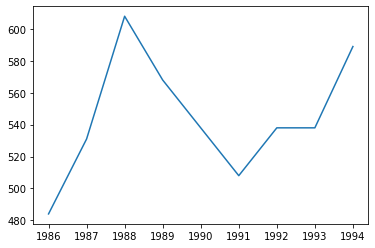

In [6]:
firms_by_date = data['date'].value_counts()
firms_by_date.sort_index().plot()
plot.show()

In [7]:
obs_by_firm = data['gvkey'].value_counts()

print(f"Firms per year is: {firms_by_date.values.mean()}")
print(f"Average observations per firm is: {obs_by_firm.values.mean()}")


Firms per year is: 544.6666666666666
Average observations per firm is: 3.7941176470588234


The decline in the number of observable firms per year might affect the treatment and control groups differently. We don't have many observations per firm in this time frame.

> 2. Winsorize all ratios (outcomes and controls) at the upper and lower one percentile. Create a table of summary statistics for all of the variables showing the number of observations, mean, median, sd, min and max.

In [8]:
# intermediate variables
data['lag_at'] = data['at'].shift()

# outcome variables
data['inv'] = (data['capxv'] - data['sppe']) / data['ppent'].shift()
data['td'] = data['dlc'] + data['dltt']
data['net_d_issue'] = (data['td'] - data['td'].shift()) / data['lag_at']
data['net_e_issue'] = (data['sstk'] - data['prstkc'].shift()) / data['lag_at']

# control variables
data['book_lev'] = data['td'] / data['at']
data['prof'] = data['oibdp'] / data['at']
data['tang'] = data['ppent'] / data['at']
data['mtb'] = ((data['prcc_f'] * data['csho']) + data['dlc'] + data['dltt'] + data['pstkl'] + data['txditc']) / data['at']
data['size'] = np.log(data['at'])

> 2. Winsorize all ratios (outcomes and controls) at the upper and lower one percentile. Create a table of summary statistics for all of the variables showing the number of observations, mean, median, sd, min and max.

In [9]:
data.dropna(inplace=True)

In [10]:
data[['inv','td','net_d_issue','net_e_issue','book_lev','prof','tang','mtb','size']] = data.groupby('gvkey')[['inv','td','net_d_issue','net_e_issue','book_lev','prof','tang','mtb','size']].transform(lambda x: winsorize(x,limits=[.01,.99]))

> 3. Define treatment and control groups as firms with a speculative-grade, i.e., junk, rating and investment-grade rating, respectively. Speculative-grade is defined as an S&P rating below BBB-. Graph the outcome variables against time for these two groups.

In [11]:
data['is_junk'] = (data['splticrm'].isin(BONDS_JK))
data['is_post1989'] = (data['date']>1989)

In [12]:
treatment_data = data[data['is_junk']]
treatment_data.set_index('date', inplace=True)

In [13]:
control_data = data[~data['is_junk']]

> 5. Run a DID regression of net debt issuance on an indicator equal to one if the firm is junk rated, an indicator equal to one if the year is after 1989, and an interaction of these two variables. Be sure to cluster the standard errors by firm to account for within firm dependence. Interpret your results.

In [27]:
d = data.set_index(['gvkey','date'])

model = PanelOLS(dependent=d['net_d_issue'],
             exog=d[['is_junk','is_post1989']],
             entity_effects=True,
             time_effects=False)

model.fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,net_d_issue,R-squared:,0.0000
Estimator:,PanelOLS,R-squared (Between):,0.0000
No. Observations:,4887,R-squared (Within):,0.0000
Date:,"Tue, Sep 27 2022",R-squared (Overall):,0.0000
Time:,23:40:54,Log-likelihood,1.845e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,0.0000
Entities:,1291,P-value,1.0000
Avg Obs:,3.7854,Distribution:,"F(2,3594)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,15.285


**Note**: This didn't quite work as I had hoped... I'll put some time into it this weekend to see if I work out all the issues.